## Setup (ignore all this stuff, scroll down to Interpretability)

In [1]:
from __future__ import print_function
import os
import sys
sys.path.append(os.path.join(os.environ['ITHEMAL_HOME'], 'learning', 'pytorch'))

In [3]:
%matplotlib inline

import numpy as np
import torch
import data.data_cost as dt
import common_libs.utilities as ut
import models.train as tr
import models.graph_models as md
import models.losses as ls
import random
from tqdm import tqdm

ImportError: No module named torch

In [4]:
data = dt.load_dataset('/home/ithemal/ithemal/learning/pytorch/inputs/embeddings/code_delim.emb', data_savefile='/home/ithemal/ithemal/learning/pytorch/saved/time_skylake_1217.data')

NameError: name 'dt' is not defined

In [5]:
embedding_size = data.final_embeddings.shape[1]
model = md.GraphNN(embedding_size, 256, 1, False)
model.set_learnable_embedding(mode = 'none', dictsize = max(data.word2id) + 1, seed = data.final_embeddings)

NameError: name 'data' is not defined

In [6]:
train = tr.Train(model, data, tr.PredictionType.REGRESSION, ls.mse_loss, 1)

NameError: name 'tr' is not defined

In [7]:
state_dict = torch.load('../saved/sgd_6x4_test.mdl')
model.load_state_dict(state_dict['model'])

NameError: name 'torch' is not defined

In [8]:
cnx = ut.create_connection(database='ithemal')
import pandas as pd
iaca_preds = pd.read_sql('SELECT time_id, code_id, kind, time FROM times WHERE time > 20 AND time < 20000 AND kind = "iaca" AND arch=2', cnx).set_index('time_id')

NameError: name 'ut' is not defined

In [9]:
train.validate('/tmp/foo')

NameError: name 'train' is not defined

In [10]:
def predict(item):
    model.remove_refs(item)
    model.init_bblstm(item)
    roots = item.block.find_roots()

    root_hidden = []
    for instr in roots:
        token_embeds_lstm = torch.FloatTensor(instr.tokens).unsqueeze(1)
        _, (ins_embed, _) = model.lstm_token(token_embeds_lstm, model.init_hidden())
        _, (ins_hidden, _) = model.lstm_ins(ins_embed, model.init_hidden())
        root_hidden.append(ins_hidden.squeeze())

    final_hidden = root_hidden[0]
    for hidden in root_hidden[1:]:
        final_hidden = model.reduction(final_hidden,hidden)
    pred = model.linear(final_hidden).squeeze()
    model.remove_refs(item)
    
    return pred, root_hidden

In [11]:
train.correct = 0
total_loss = 0

for datum in data.test:
    pred, _ = predict(datum)
    y = torch.FloatTensor([datum.y]).squeeze()
    total_loss += ls.mse_loss(pred, y)[0].item()
    train.correct_regression(pred, y)

print('Test loss: {:.2f}'.format(total_loss / float(len(data.test))))
print('Test accuracy: {:.2f}'.format(train.correct / float(len(data.test))))

NameError: name 'train' is not defined

## Interpretability

Since this is a simple model (LSTM cell on each instruction embedding, `max` to combine instruction embeddings, then a linear layer), we can get some interpretable results:
- `desire`, the prediction of the given instruction if it were the only instruction in the block
- `weight`, the percentage of the (absolute value) weight in the linear layer that is multiplied by each slot in the final vector where the instruction won the `max`
- `total contrib`, the actual contribution of the instruction to the final prediction (the slots where it won `max` times the weights of those slots)

In [12]:
item = data.test[21]

pred, root_hidden = predict(item)

total_weight = model.linear.weight.data.squeeze().abs().sum()

for i in range(len(root_hidden)):
    max_vals, max_idxs = torch.stack(root_hidden).max(dim=0)
    idxs = np.where(max_idxs.data.numpy() == i)
    i_vals = max_vals[idxs]
    i_weights = model.linear.weight.data.squeeze()[idxs]
    i_weight_perc = 100 * i_weights.abs().sum() / total_weight
    i_w_contrib = (i_weights * i_vals).sum()
    i_desire = (model.linear(root_hidden[i])).squeeze().sum().item()
    print('{:<60}: desire {:6.2f}, weight {:2.0f}%, total contrib {:6.2f}'.format(
        item.block.instrs[i],
        i_desire,
        i_weight_perc,
        i_w_contrib,
    ))

print('\npred: {:.2f}, actual: {:.2f}'.format(
    pred.item(),
    item.y,
))

NameError: name 'data' is not defined

### What is the best we could do if we were to have a constant prediction

In [13]:
import itertools
from tqdm import tqdm

dataset = data.train

starts = [None] * len(dataset)
ends = [None] * len(dataset)

for i, datum in enumerate(dataset):
    starts[i] = datum.y * 0.75
    ends[i] = datum.y * 1.25

starts.sort()
ends.sort()

xs = []
ys = []

max_val = 0
max_count = 0
curr_count = 0
for val, typ in sorted(itertools.chain(zip(starts, itertools.repeat('start')), zip(ends, itertools.repeat('end')))):
    if typ == 'start':
        curr_count += 1
        if curr_count > max_count:
            max_count = curr_count
            max_val = val
    elif typ == 'end':
        curr_count -= 1
    xs.append(val)
    ys.append(curr_count)

NameError: name 'data' is not defined

NameError: name 'xs' is not defined

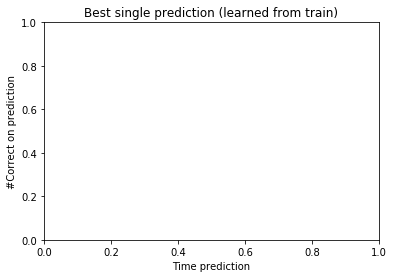

In [14]:
from matplotlib import pyplot as plt
plt.xlabel('Time prediction')
plt.ylabel('#Correct on prediction')
plt.title('Best single prediction (learned from train)')
plt.plot(xs, ys)
plt.show()

In [15]:
m_prediction = xs[np.argmax(ys)]
actual = np.array([datum.y for datum in data.test])
single_prediction = np.ones_like(actual) * m_prediction + 1e-2

NameError: name 'xs' is not defined

In [16]:
n_correct = np.sum(np.abs(actual - single_prediction) / (single_prediction + 1e-3) * 100 < 25)
print('Correct: {}'.format(n_correct / float(len(data.test))))

NameError: name 'actual' is not defined